In [232]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit

from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation as R


In [233]:
#starship entry coefficients
flat_area = 665 * (u.m**2)
dry_mass = 150*10e3 * u.kg
a_m = (flat_area/dry_mass).value

AoA = 60


#lifting area is reduced by some factor from drag area
a_m_l = (flat_area/dry_mass*0.5).value

#typical hypersonic regime, lift coefficient is ~ 3.7, drag ~ 9.5, l/d ~ 0.4    
# or, c_l = ~0.45, & c_d = 0.9 at AoA 60
# c_d =8.5
# c_l=4
d_factor = 2
c_d = 0.9
c_l = 0.45

#rotation around AoA circle, top is away from Earth
rot = 0




#calculated at mach 12, >40deg AoA
def lift(AoA):
    lift_over_drag=1-((AoA-40)/50)
    return lift_over_drag
print(lift(60))


0.6


In [234]:
#Earth has an atmosphere and some gravity
atmosphere = COESA76()
mu = Earth.k.to(u.km**3/u.s**2).value

#ignore
density = 0

orbit = Orbit.circular(Earth,alt=250*u.km)
orb_fin = orbit


#deorbit_dv = (v_apo - np.linalg.norm(orbit.v)).value
deorbit_dv = -85 #971 from 250000 leads to 30k, 973 leads to -40k
print(f"deorbit dv is {deorbit_dv}m/s")


ov1 = orbit.v
prograde_norm= ((orbit.v.value*u.km/u.s)/((ov1[0]**2 + ov1[1]**2 + ov1[2]**2)**.5).value)
man = Maneuver((0 * u.s, deorbit_dv*10e-4*prograde_norm))
orbit = orbit.apply_maneuver(man)
print(orbit)
print(f"Initial apogee of {orbit.r_a-Earth.R}")
print(f"Initial perigee of {orbit.r_p-Earth.R}")


deorbit dv is -85m/s
6345 x 6628 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
Initial apogee of 249.9999999999991 km
Initial perigee of -32.8420251479256 km


In [235]:

prop_total = 500
reentry_vel = []
reentry_time = []
reentry_alts = []
entry_interface = 0


def reentry_accel(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        square_v = (v[0]**2 + v[1]**2 + v[2]**2) #km^2/s^2
        norm_v = square_v**.5
        p = state[:3]
        alt = 10e-4*(np.linalg.norm(state)*10e2-Earth.R.value)*u.km#alt in km, not sure what these dumbass 1/10th of a metre units are

        global orb_fin
        global entry_interface
        global reentry_vel
        global reentry_time
        global reentry_alts

        if alt<999*u.km:
            density = 0*u.kg/(u.m**3)
            if(alt>0):
                density = atmosphere.properties(alt)[2]#kg/m^3

            #f_d = 0.5*rho*v^2*C_d*a
            # print(f"density at {alt} is {density}")
            # print(square_v)
            #square_v is km^2/s^2 so convert to m^2/s^2, and then convert final acceleration from m/s^2 to km/s^2
            #print((v))
            drag_acc = -0.5*density.value*square_v*10e6*c_d*a_m * v * 10e-3 / (norm_v )# km/s^2
            AoA_lift_rot = R.from_euler('z',-90,degrees=True)
            #lift vector
            lift_vec = AoA_lift_rot.apply(v)
            # print(v)
            # print(f"rotate {lift_vec}")

            # lift_acc = 0*lift_vec
            # if alt<75*u.km:
            lift_acc = 0.5*a_m_l*c_l*square_v*density.value*10e6*lift_vec*10e-3/(norm_v)
            #lift_acc = lift_vec*10e-2/(norm_v)
            # print(f"lift {np.linalg.norm(lift_acc)}")
            # print(f"drag {np.linalg.norm(drag_acc)}")


            #0.5*10e-11*10e7
            orb_fin = Orbit.from_vectors(Earth, p*u.km, v*u.km/u.s)
            if alt <120*u.km and entry_interface == 0:
                entry_interface = t0
            if alt <120*u.km:
                reentry_vel.append(norm_v)
                reentry_time.append(t0)
                reentry_alts.append(alt.value)


            #print(acc)
            return d_factor*(drag_acc+lift_acc)
        else:
            return 0*v

    return constant_accel



lithobrake_event = LithobrakeEvent(Earth.R.to(u.km).value)
events = [lithobrake_event]  

prop_time = 1 * orbit.period
times = np.linspace(0, prop_time, prop_total)
times
positions = propagate(
    orbit,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-10,
    ad=reentry_accel(10e-5),
    events = events
)
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")






# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.s, prop_time.to(u.s), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

Entry interface at 1252.3804681641693 seconds
Lithobrake event seen at 2961.1231430727294 seconds


Entry interface at 1252.3804681641693 seconds
Lithobrake event seen at 2961.1231430727294 seconds
Final apogee of 0.009349759404358338 km
Final perigee of -6378.1360146465095 km


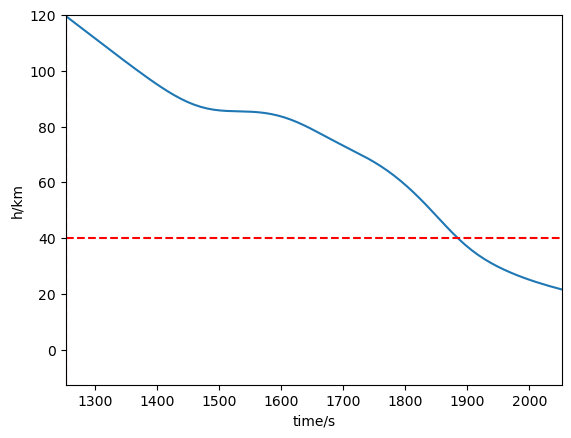

In [236]:
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


print(f"Final apogee of {orb_fin.r_a-Earth.R}")
print(f"Final perigee of {orb_fin.r_p-Earth.R}")
plt.ylabel("h/km")
# plt.xlabel("distance downrange, km")
plt.xlabel("time/s")
#plt.axhline(impact_time)

#plt.xlim(12500,14000)
#plt.ylim(top = 100)
plt.plot(tofs, pos_spherical.distance - Earth.R)
plt.xlim(left=entry_interface,right=entry_interface+800)
plt.axvline(x=entry_interface,color = 'r',label='entry_interface',linestyle = '--')
plt.axhline(y=40,color = 'r',label='entry_interface',linestyle = '--')
plt.ylim(top=120)
#plt.axvline(x=entry_interface,color = 'r',label='entry_interface')
plt.show()


In [237]:
#calculate the accelerations
reentry_accs = np.diff(np.array(reentry_vel))/np.diff(np.array(reentry_time)+1)

C:\Users\jacki\AppData\Local\Temp\ipykernel_11980\3161186587.py:2: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\jacki\AppData\Local\Temp\ipykernel_11980\3161186587.py:2: RuntimeWarning:

invalid value encountered in true_divide



Entry interface at 1252.3804681641693 seconds
Lithobrake event seen at 2961.1231430727294 seconds


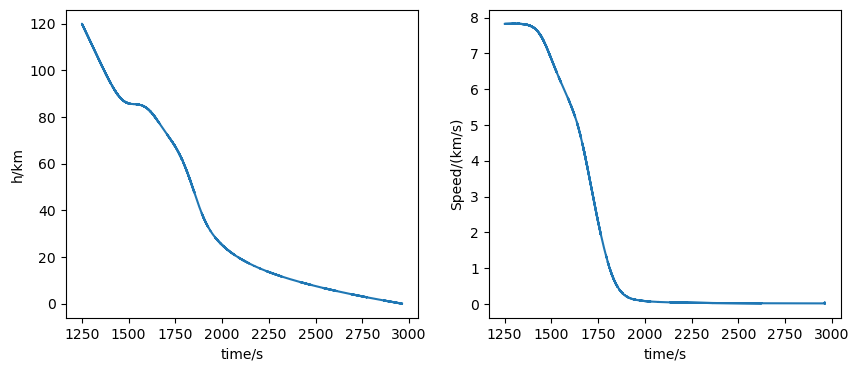

In [238]:

impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
ax1.plot(np.array(reentry_time),np.array(reentry_alts))
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
#plt.ylim(15)
ax2.set_xlabel("time/s")
ax2.set_ylabel("Speed/(km/s)")
ax2.plot(np.array(reentry_time),np.array(reentry_vel))




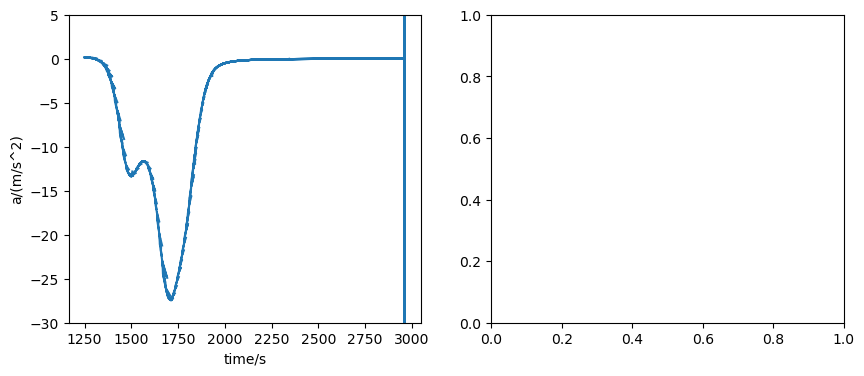

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("a/(m/s^2)")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
#plt.ylim(150)
#ax1.set_xlim(2600)
ax1.set_ylim(top = 5, bottom = -30)
ax1.plot(np.array(reentry_time)[:-1],np.array(reentry_accs)*1000)